# Animal Classification

## Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as du
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2 
import numpy as np
from tqdm import tqdm

## Loading Dataset

In [2]:
# https://www.kaggle.com/datasets/virtualdvid/oregon-wildlife
def load_dataset(data_path, save_data_path, image_size, saved=False):
    '''
    data_path: directory containing where images of the same label are stored in the same subfolder
    save_data_path: location to store processed dataset
    saved: if True, load array from save_data_path. If false, dataset needs to be created from data_path
    '''
    if(saved):
        with open(save_data_path, 'rb') as f:
            dataset = np.load(f)
            labels = np.load(f)
            return dataset, labels
    start_path = os.getcwd()
    os.chdir(data_path)
    dataset = []
    labels = []
    label_idx = 0
    folder_list = os.listdir('./')
    for folder in tqdm(folder_list):  # each folder stores one label
        os.chdir(folder)
        file_list = os.listdir('./')
        for file in file_list:   # iterating through each folder and saving img along with its label
            img = cv2.imread(file)
            if(img is not None): # save img if reading image is successful
                dataset.append(cv2.resize(img, image_size))
                labels.append(label_idx)
        label_idx += 1
        os.chdir("./..")
    os.chdir(start_path)
    dataset = np.array(dataset, dtype=np.uint8)
    labels = np.array(labels, dtype=np.uint8)
    with open(save_data_path, 'wb') as f:  # saving dataset because it takes a long time to generate it every time
        np.save(f, dataset, allow_pickle=True)
        np.save(f, labels, allow_pickle=True)
        return dataset, labels

In [3]:
def split_dataset(dataset, labels, split=np.array([.8,.1,.1])):
    '''
    dataset: features
    labels: labels
    split: train/val/test 
    returns a three tuples of (dataset, labels) for train/val/test splits
    '''
    assert(np.sum(split) == 1)
    split = np.cumsum(split)
    permutation = np.random.permutation(labels.shape[0])
    dataset = dataset[permutation]
    labels = labels[permutation]
    dataset = np.einsum("bijc->bcij", dataset)
    train_data = (dataset[:int(dataset.shape[0]*split[0])], labels[:int(dataset.shape[0]*split[0])])
    valid_data = (dataset[int(dataset.shape[0]*split[1]):int(dataset.shape[0]*split[2])], labels[int(dataset.shape[0]*split[1]):int(dataset.shape[0]*split[2])])
    test_data = (dataset[int(dataset.shape[0]*split[1]):], labels[int(dataset.shape[0]*split[1]):])
    return train_data, valid_data, test_data


## Preprocessing and displaying images

Size of Training Set 11160
Size of Validation Set 1396
Size of Testing Set 1396


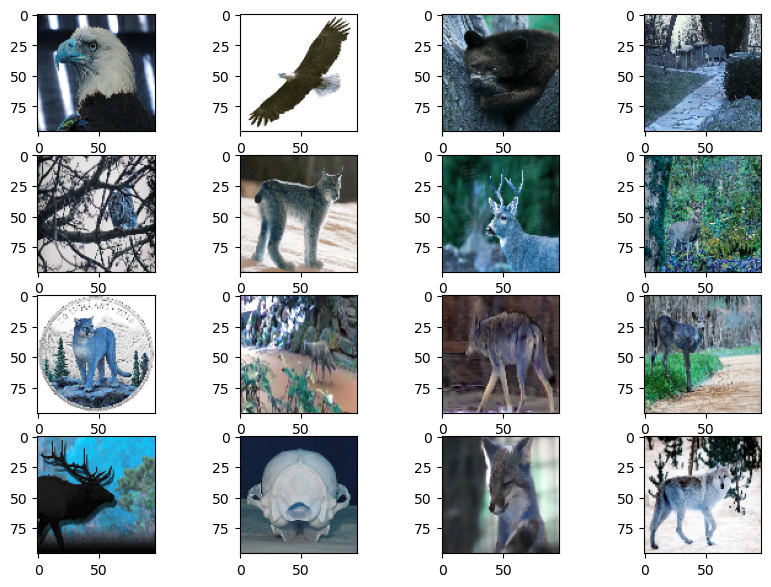

In [4]:
dataset, labels = load_dataset("./Datasets/oregon_wildlife", "./Datasets/wildlife_dataset.npy", (96, 96), True)
fig = plt.figure(figsize=(10, 7))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(dataset[i*500])
train_data, valid_data, test_data = split_dataset(dataset, labels)
print(f"Size of Training Set {train_data[0].shape[0]}")
print(f"Size of Validation Set {valid_data[0].shape[0]}")
print(f"Size of Testing Set {test_data[0].shape[0]}")

## Visualizing Dataset

## Dataset Class

In [5]:
class Image_Dataset(Dataset):
    def __init__(self, data):
        '''
        data: tuple of (features, labels)
        '''
        super(Image_Dataset, self).__init__()
        self.images = torch.tensor(data[0], dtype=torch.float)
        self.images[:,0] = (self.images[:,0]-torch.mean(self.images[:,0])) / torch.std(self.images[:,0])
        self.images[:,1] = (self.images[:,1]-torch.mean(self.images[:,1])) / torch.std(self.images[:,1])
        self.images[:,2] = (self.images[:,2]-torch.mean(self.images[:,2])) / torch.std(self.images[:,2])
        self.labels = torch.tensor(data[1], dtype=torch.long)

    def __len__(self):
        '''return len of dataset'''
        return self.images.shape[0]
        
    def __getitem__(self, idx):
        '''return sequence, future sequence'''
        return self.images[idx], self.labels[idx]

In [6]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes, pretrain = False):
        '''
        in_dim: input layer dim
        hidden_layers: hidden layers in lstm
        '''
        super(CNN, self).__init__()
        self.flatten = nn.Flatten()
        if(pretrain == True):
            mobilenetv2 = models.mobilenet_v2(pretrained=True)
            self.backbone = nn.Sequential(*list(mobilenetv2.children())[:-1])
            for param in self.backbone.parameters():
                param.requires_grad = False
            self.linear = nn.Sequential(
                            nn.Linear(11520, 6000),
                            nn.ReLU(),
                            nn.Linear(6000, 1000),
                            nn.ReLU(),
                            nn.Linear(1000, 500),
                            nn.ReLU(),
                            nn.Linear(500, num_classes),
                        )
        else:
            cnn_stack = []
            cnn_stack.append(nn.Conv2d(3, 64, (5,5)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(64, 64, (5,5)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.MaxPool2d((3,3)))
            cnn_stack.append(nn.Conv2d(64, 128, (4,4)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(128, 128, (3,3)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.Conv2d(128, 128, (3,3)))
            cnn_stack.append(nn.ReLU())
            cnn_stack.append(nn.MaxPool2d((3,3)))
            self.backbone = nn.Sequential(*cnn_stack)
            self.linear = nn.Sequential(
                            nn.Linear(6272, 1000),
                            nn.ReLU(),
                            nn.Linear(1000, 500),
                            nn.ReLU(),
                            nn.Linear(500, num_classes),
                        )
    def forward(self, x):
        x = self.flatten(self.backbone(x))
        x = self.linear(x)

        return x

In [7]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

# hyper parameters
batch_size = 64
learning_rate = 1e-4
epochs = 15
in_channels = 3
num_classes = 20

#initializing model and optimizer
model = CNN(in_channels, num_classes, False)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = du.DataLoader(dataset=Image_Dataset(train_data),
                             batch_size=batch_size,
                             shuffle=True)
valid_loader = du.DataLoader(dataset=Image_Dataset(valid_data),
                             batch_size=batch_size,
                             shuffle=True)
test_loader = du.DataLoader(dataset=Image_Dataset(test_data),
                             batch_size=batch_size,
                             shuffle=True)

# sending model to device
model.to(device)
# set model to training mode
model.train()

using device: cuda:0


CNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=6272, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=20, bias=True)
  )
)

## Training Crafted Model

In [8]:
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
# iterating through all epochs
for epoch in range(1, epochs+ 1):    
    # training step
    train_loss = 0.
    model.train()

    # iterating through entire dataset in batches
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):

        # sending batch over to device
        data, target = data.to(device), target.to(device)

        # zeroing out previous gradients
        optimizer.zero_grad()

        # getting predictions from model
        output = model(data)

        # claculating cross entropyloss
        loss = F.cross_entropy(output, target)

        train_loss += loss.item()

        # Gradient Descent and Backprop
        loss.backward()
        optimizer.step()
    
    # validation step
    valid_loss = 0

    # turning off gradient for validation step
    model.eval()
    valid_loss = 0
    valid_acc = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(valid_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            valid_loss += loss.item()
            output = F.softmax(output, dim=-1)
            pred = torch.argmax(output, dim=-1)
            correct = torch.sum(pred == target, dtype=torch.float)
            valid_acc += correct
    
    train_loss /= len(train_loader.dataset)
    valid_loss /= len(valid_loader.dataset)
    valid_acc /= len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    valid_acc_list.append(valid_acc.detach().cpu().numpy())

    # printing loss per epoch
    print(f"Epoch: {epoch}, Training Loss: {train_loss}, Validation Loss: {valid_loss}, Validation Accuracy: {valid_acc}")

100%|██████████| 22/22 [00:01<00:00, 11.73it/s]


Epoch: 1, Training Loss: 0.04297975391469976, Validation Loss: 0.04077375549983159, Validation Accuracy: 0.19412608444690704


100%|██████████| 22/22 [00:01<00:00, 11.75it/s]


Epoch: 2, Training Loss: 0.03846780664177351, Validation Loss: 0.037698379901896915, Validation Accuracy: 0.2550143301486969


100%|██████████| 22/22 [00:01<00:00, 11.95it/s]


Epoch: 3, Training Loss: 0.0350314089474285, Validation Loss: 0.03459553988410272, Validation Accuracy: 0.3037249445915222


100%|██████████| 22/22 [00:01<00:00, 11.98it/s]


Epoch: 4, Training Loss: 0.030689905354199017, Validation Loss: 0.030573403254621007, Validation Accuracy: 0.4018624722957611


100%|██████████| 22/22 [00:01<00:00, 12.08it/s]


Epoch: 5, Training Loss: 0.02453883400313743, Validation Loss: 0.027459711519558314, Validation Accuracy: 0.49570202827453613


100%|██████████| 22/22 [00:01<00:00, 12.10it/s]


Epoch: 6, Training Loss: 0.017718516354278853, Validation Loss: 0.022769930924590474, Validation Accuracy: 0.6117478609085083


100%|██████████| 22/22 [00:01<00:00, 12.14it/s]


Epoch: 7, Training Loss: 0.010594076524391824, Validation Loss: 0.02078539474645795, Validation Accuracy: 0.707020103931427


100%|██████████| 22/22 [00:01<00:00, 12.07it/s]


Epoch: 8, Training Loss: 0.0055194107488492055, Validation Loss: 0.01953090714520233, Validation Accuracy: 0.7729226350784302


100%|██████████| 22/22 [00:01<00:00, 12.00it/s]


Epoch: 9, Training Loss: 0.0029515498127507906, Validation Loss: 0.021616334901498176, Validation Accuracy: 0.7836676239967346


100%|██████████| 22/22 [00:01<00:00, 12.09it/s]


Epoch: 10, Training Loss: 0.0019404087955045338, Validation Loss: 0.02530490493876886, Validation Accuracy: 0.7700573205947876


100%|██████████| 22/22 [00:01<00:00, 11.70it/s]


Epoch: 11, Training Loss: 0.0016678531062505526, Validation Loss: 0.024544866558132334, Validation Accuracy: 0.7908309698104858


100%|██████████| 22/22 [00:01<00:00, 11.99it/s]


Epoch: 12, Training Loss: 0.0011414453245809561, Validation Loss: 0.0222427158864658, Validation Accuracy: 0.8030086159706116


100%|██████████| 22/22 [00:01<00:00, 12.09it/s]


Epoch: 13, Training Loss: 0.0011834061712086682, Validation Loss: 0.022790582610406302, Validation Accuracy: 0.8051576018333435


100%|██████████| 22/22 [00:01<00:00, 11.98it/s]


Epoch: 14, Training Loss: 0.0007650281582194578, Validation Loss: 0.024343026444358606, Validation Accuracy: 0.8094556331634521


100%|██████████| 22/22 [00:01<00:00, 11.81it/s]

Epoch: 15, Training Loss: 0.0006621769534283749, Validation Loss: 0.02656467880167729, Validation Accuracy: 0.8080229759216309


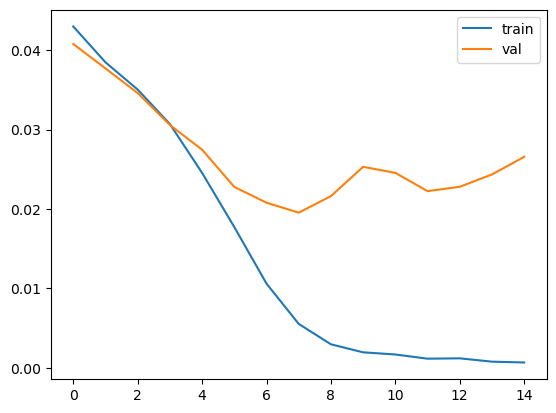

In [9]:
plt.plot(train_loss_list, label="train")
plt.plot(valid_loss_list, label="val")
plt.legend()
plt.show()

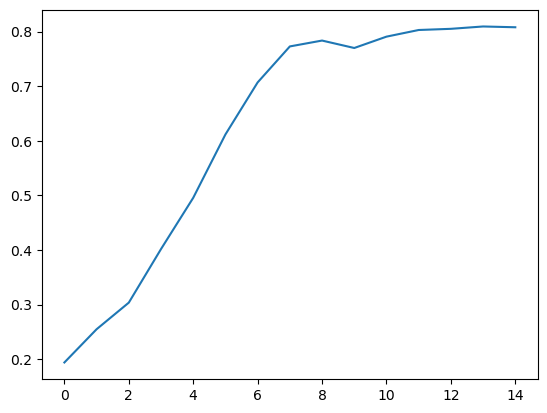

In [10]:
plt.plot(valid_acc_list)
plt.show()

In [12]:
test_loss = 0.
test_acc = 0.
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = F.cross_entropy(output, target)
        test_loss += loss.item()
        output = F.softmax(output, dim=-1)
        pred = torch.argmax(output, dim=-1)
        correct = torch.sum(pred == target, dtype=torch.float)
        test_acc += correct

test_loss /= len(test_loader.dataset)
test_acc /= len(test_loader.dataset)

# printing loss per epoch
print(f"test loss: {test_loss}, test accuracy: {test_acc}")

100%|██████████| 22/22 [00:03<00:00,  5.55it/s]

test loss: 0.02647981957070807, test accuracy: 0.8080229759216309


## Write Up
I based my architecture roughly on VGG where my pattern was having 2-3 convolutional layers with ReLU activation followed by a maxpool layer. In addition, I chose to vary the size of my kernels so that the model could learn the representation of both large and small features. After roughly 10 epochs, the model started to converge and validaiton accuracy plauteued at 81%. For evaluating the performance, I decided to use accuracy as my metric because my dataset is balanced and accuracy is a good metric for classification. After 20 epochs, the model reached an accuracy of 81% for validation and testing datasets.